In [10]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [11]:
# Đọc file dữ liệu
df = pd.read_csv("C:\\Users\\ADMIN\\Downloads\\VCBB.csv")

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.8 * len(df))
test_size = len(df1) - train_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

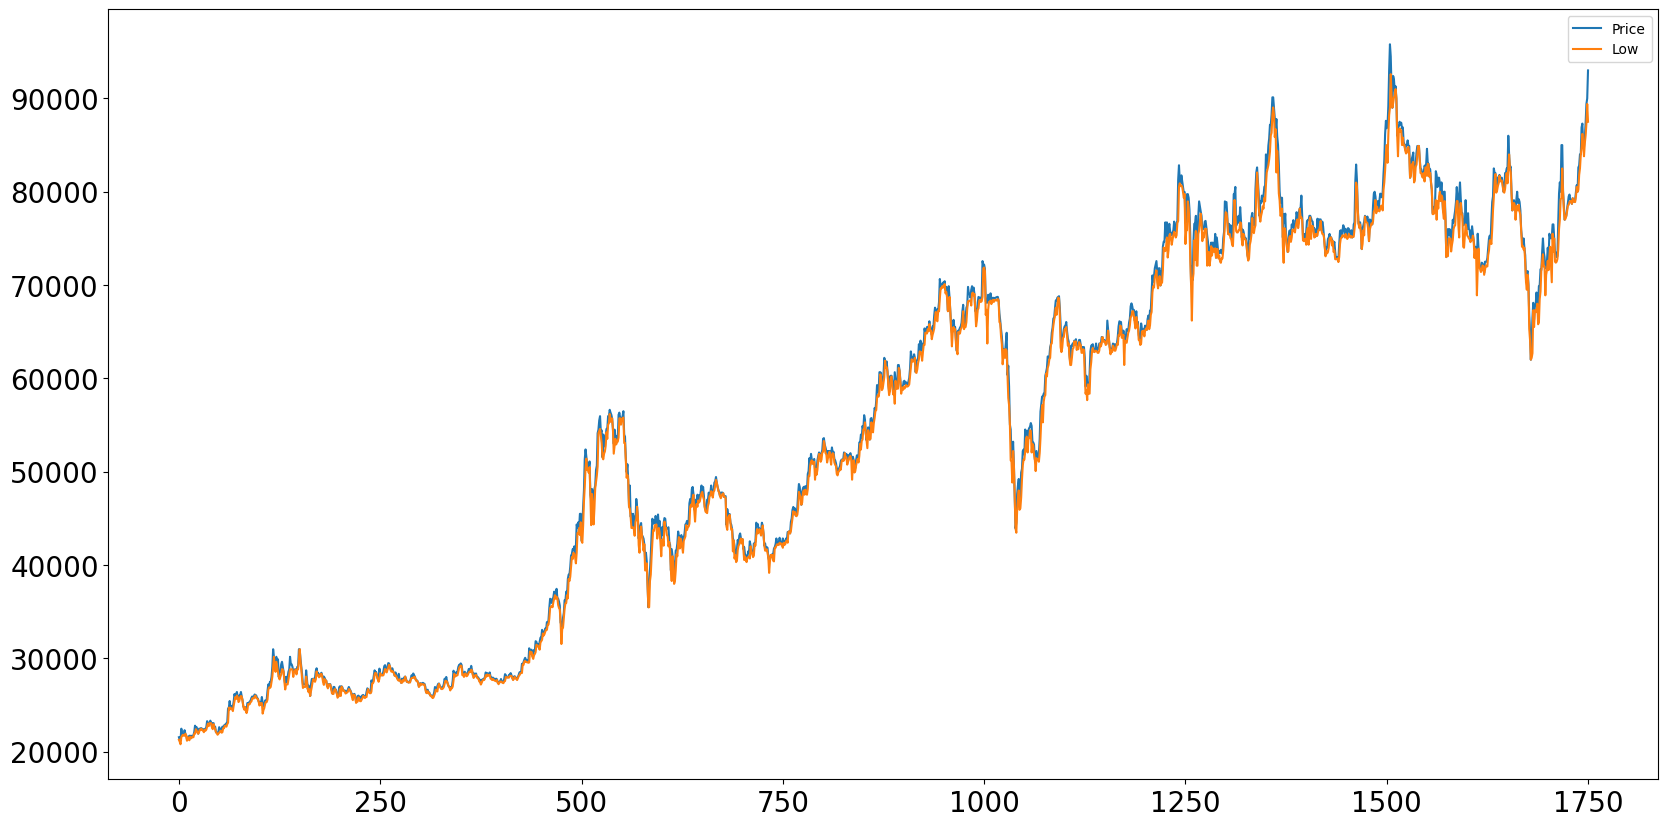

In [12]:
# Xem lại dataset
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

In [13]:
# Tìm m thích hợp
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-0.8600955336273238,
 0.8008294392866551,
 0,
 1750,
 {'1%': -3.4340922388213175,
  '5%': -2.863192990001633,
  '10%': -2.5676500029387754},
 28958.721362774268)

In [14]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [15]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-14.573346314670854,
 4.5906577968256565e-27,
 8,
 1741,
 {'1%': -3.4341116127463858,
  '5%': -2.863201542300677,
  '10%': -2.567654556829725},
 28941.62014397561)

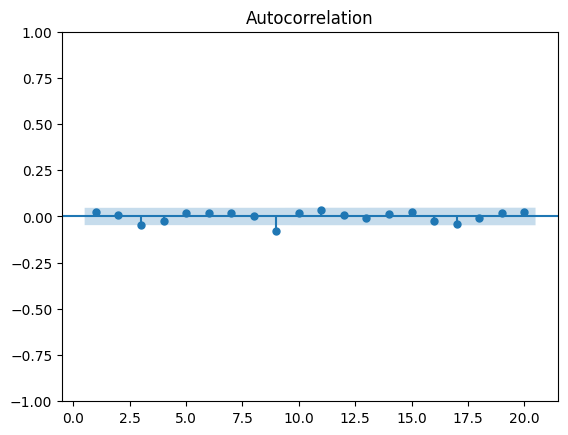

In [16]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

In [17]:
df

,Price,Low
0,21552,21283
1,21229,21067
2,21337,20798
3,22468,21552
4,21876,21714
...,...,...
1746,85800,85200
1747,87300,86000
1748,89400,87300
1749,90000,89400


In [18]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=23225.159, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=23216.513, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=23217.626, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=23217.615, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=23216.678, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=23215.869, Time=0.11 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=23217.836, Time=0.17 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=23217.771, Time=0.21 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=23215.837, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=23217.802, Time=0.13 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=23219.771, Time=0.68 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=23217.589, Time=0.09 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=23216.821, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[5]             : AIC=23215.845, Time=0.04 sec

Best model:  ARIMA

In [19]:
# Dùng SARIMAX để train model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(2,1,2), seasonal_order=(1, 0, 0, 5))
model_fit = model1.fit()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
# Quá trình test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([74322., 75716., 76103., 74322., 76955., 77264., 74942., 76335.,
       76335., 75948., 75096., 75174., 75484., 75251., 75329., 75871.,
       75871., 76258., 76877., 75871., 75484., 75484., 75174., 74167.,
       73084., 73626., 73393., 73548., 74013., 74942., 75096., 75096.,
       74245., 74709., 73548., 73703., 72774., 72774., 72774., 72851.,
       72464., 73006., 74400., 75019., 75096., 75329., 75329., 75251.,
       75096., 75484., 75096., 74942., 75096., 75484., 75251., 75096.,
       75251., 75096., 75174., 75174., 76025., 76800., 80980., 80516.,
       78193., 76567., 76103., 76490., 75484., 73858., 74400., 75871.,
       75329., 77342., 76800., 76722., 76645., 75948., 74709., 75948.,
       76258., 76600., 76500., 76800., 77900., 78000., 79100., 77700.,
       78400., 78000., 78000., 77900., 78200., 78500., 78500., 78000.,
       80200., 81000., 82300., 84000., 85000., 83100., 86100., 88200.,
       89000., 92600., 90400., 89000., 89500., 90100., 90300., 91000.,
      

In [21]:
# Quá trình tạo index predict 30 ngày tiếp theo
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Price'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị price 30 ngày tiếp theo
price_next_30_days = ln_model.predict(x_next_30_days)

# Predict prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=price_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted prices for the next 30 days:')
print(y_next_30_days)

Predicted prices for the next 30 days:
[93886.88627684 93930.16674405 93973.44721127 94016.72767848
 94060.0081457  94103.28861291 94146.56908013 94189.84954735
 94233.13001456 94276.41048178 94319.69094899 94362.97141621
 94406.25188342 94449.53235064 94492.81281785 94536.09328507
 94579.37375228 94622.6542195  94665.93468671 94709.21515393
 94752.49562114 94795.77608836 94839.05655557 94882.33702279
 94925.61749    94968.89795722 95012.17842444 95055.45889165
 95098.73935887 95142.01982608]


In [22]:
# Đánh giá độ chính xác thuật toán với MAPE
# RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Testing RMSE:', test_rmse)

# MAPE (thay thế MSE bằng MAPE)
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Testing MAPE:', test_mape)

# MAE
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Testing MAE:', test_mae)


Testing RMSE: 1511.3839764323704
Testing MAPE: 1.2650218201912615
Testing MAE: 1002.8689458689458


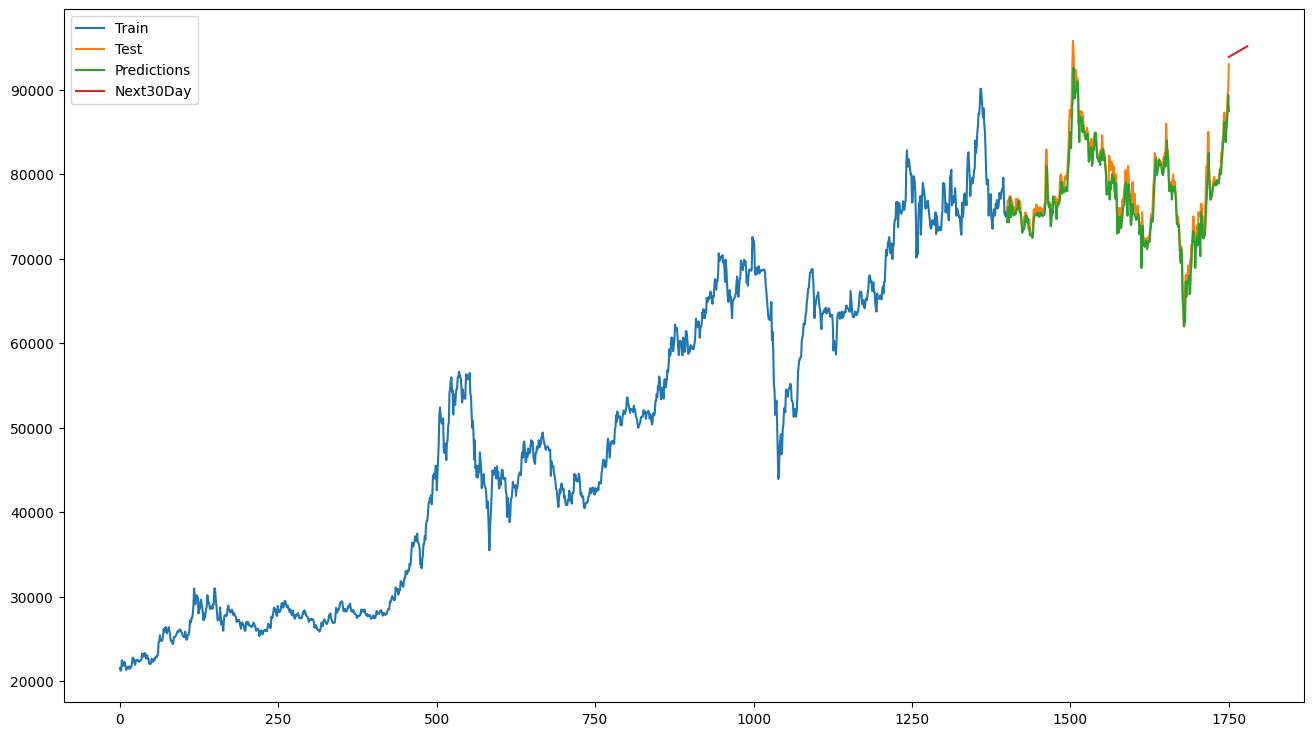

In [23]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()